In [1]:
import geopandas as gpd
import pandas as pd

# 1) Load NUTS **polygons** (RG), not BN lines
#   Use the RG layer matching your scale/CRS, e.g. 01M in EPSG:3035
# we can find it at: https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_01M_2021_3035.shp.zip
nuts = gpd.read_file("NUTS_RG_01M_2021_3035/NUTS_RG_01M_2021_3035.shp")[["NUTS_ID", "LEVL_CODE", "geometry"]]

# Pick your level: 2 or 3. You had 3 before, so keep it.
nuts2 = nuts[nuts["LEVL_CODE"] == 2].copy()

# 2) Load WWF **polygons**
#   Can be found at: https://figshare.com/ndownloader/files/37264516
eco = gpd.read_file("WWF ecoregions/wwf_terr_ecos.shp")[["ECO_NAME", "ECO_ID", "geometry"]]

# 3) Reproject WWF to match NUTS (EPSG:3035 here)
eco = eco.to_crs(nuts2.crs)

# 4) Quick geometry fixes (helps avoid empty intersections from slight invalidities)
nuts2["geometry"] = nuts2.buffer(0)
eco["geometry"]  = eco.buffer(0)

# 5) Spatial intersection (polygon ∩ polygon)
overlay = gpd.overlay(nuts2, eco, how="intersection", keep_geom_type=True)

# Keep only polygonal results (paranoia check)
overlay = overlay[overlay.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

# 6) Compute area shares per NUTS
#    EPSG:3035 is meter-based; area / 1e6 => km²
overlay["area_km2"] = overlay.geometry.area / 1e6

# Guard against zero/empty geometries
overlay = overlay[overlay["area_km2"] > 0].copy()

# Total NUTS area (sum of intersected pieces equals original, modulo slivers)
total_area = overlay.groupby("NUTS_ID", as_index=False)["area_km2"].sum().rename(columns={"area_km2": "total_area_km2"})

overlay = overlay.merge(total_area, on="NUTS_ID", how="left")
overlay["share_in_nuts"] = overlay["area_km2"] / overlay["total_area_km2"]

# (Optional) sanity checks
assert overlay["share_in_nuts"].between(0, 1).all()


In [3]:
nuts2["nuts_area_km2"] = nuts2.geometry.area / 1e6
sum_overlay = overlay.groupby("NUTS_ID")["area_km2"].sum().rename("sum_intersections_km2")
chk = nuts2.merge(sum_overlay, on="NUTS_ID", how="left")

chk["rel_diff"] = (chk["sum_intersections_km2"] - chk["nuts_area_km2"]) / chk["nuts_area_km2"]
# Expect rel_diff close to 0; allow tiny tolerance due to slivers/topology (e.g., ±1%)
bad = chk[chk["rel_diff"].abs() > 0.02]  # investigate these
print("Regions with >2% area mismatch:", len(bad))


Regions with >2% area mismatch: 48


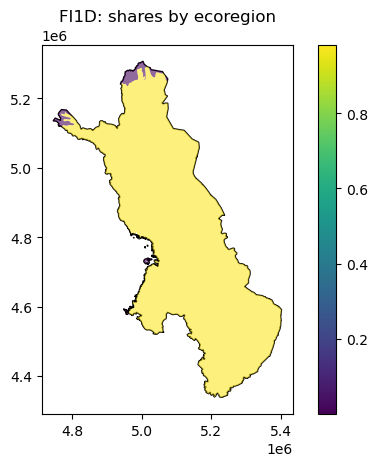

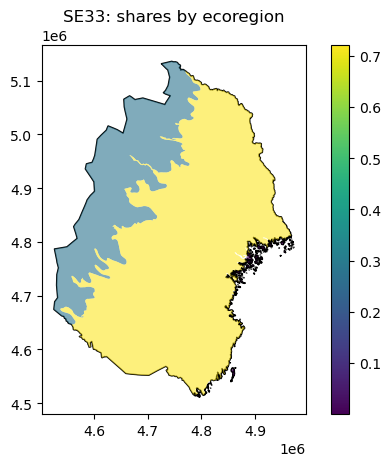

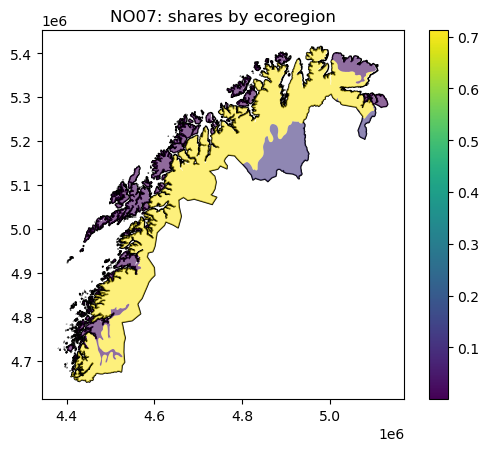

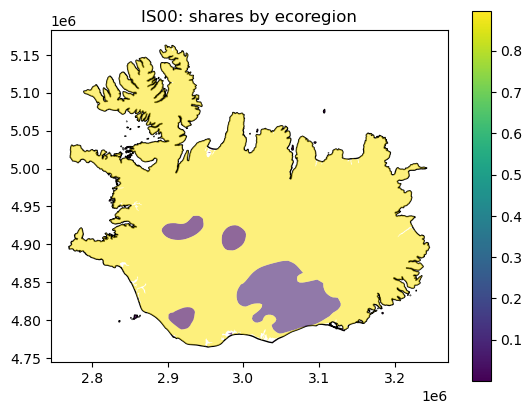

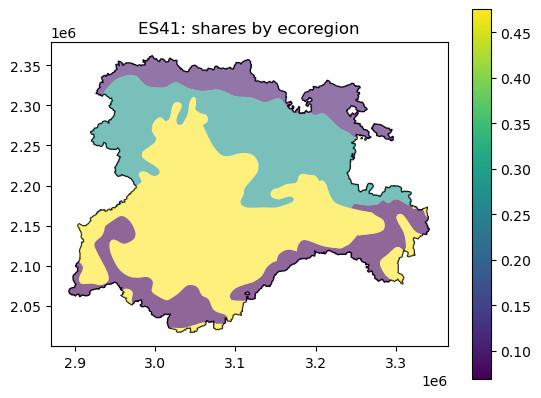

In [4]:
import matplotlib.pyplot as plt
sample_ids = chk.nlargest(5, "nuts_area_km2")["NUTS_ID"].tolist()  # or random sample

for nid in sample_ids:
    base = nuts2[nuts2["NUTS_ID"]==nid]
    parts = overlay[overlay["NUTS_ID"]==nid].copy()
    ax = base.plot(edgecolor="black", facecolor="none", linewidth=1)
    parts.plot(ax=ax, column="share_in_nuts", legend=True, alpha=0.6)
    plt.title(f"{nid}: shares by ecoregion")
    plt.show()
